In [12]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import sklearn
from functools import partial
from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datashader as ds
import datashader.transfer_functions as dtf
from datashader.mpl_ext import dsshow

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import RandomNormal, GlorotUniform
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import kl_divergence

import umap
import hdbscan
from mdutils.mdutils import MdUtils

#FLP_path = pathlib.Path('/home/relogu/Desktop/OneDrive/UNIBO/Magistrale/Federated Learning Project').absolute()
FLP_path = pathlib.Path('/home/STUDENTI/lorenzo.sani/Federated-Learning-Project').absolute()
sys.path.insert(1, str(FLP_path))

from py.losses import get_keras_loss
from py.dec.util import create_denoising_autoencoder, create_clustering_model, target_distribution
import py.metrics as my_metrics
from py.util import compute_centroid_np, get_dims_from_weights

#results_path = pathlib.Path('/home/relogu/Desktop/OneDrive/UNIBO/Magistrale/Federated Learning Project/bmnist_adam_glorotiuninit/output_bmnist')
results_path = pathlib.Path('/home/STUDENTI/lorenzo.sani/Federated-Learning-Project/bmnist_adam_glorotiuninit/output_bmnist')
N_CLUSTERS = 10
LOSS = 'bce'

gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[2], 'GPU')
# disable possible gpu devices for this kernel
# tf.config.set_visible_devices([], 'GPU')

In [2]:
# prefix = 'aggregated_weights_'
encoder_param = np.load(results_path/str('encoder.npz'),
                        allow_pickle=True)
encoder_param = np.squeeze(np.array([encoder_param[p] for p in encoder_param]))
encoder_ft_param = np.load(results_path/str('encoder_ft.npz'),
                           allow_pickle=True)
encoder_ft_param = np.squeeze(np.array([encoder_ft_param[p] for p in encoder_ft_param]))
encoder_final_param = np.load(results_path/str('encoder_final.npz'),
                              allow_pickle=True)
encoder_final_param = np.squeeze(np.array([encoder_final_param[p] for p in encoder_final_param]))
initial_centroids = np.load(results_path/'initial_centroids.npz',
                            allow_pickle=True)
initial_centroids = np.squeeze(np.array([initial_centroids[p] for p in initial_centroids]))
final_centroids = np.load(results_path/str('final_centroids.npz'),
                          allow_pickle=True)
final_centroids = np.squeeze(np.array([final_centroids[p] for p in final_centroids]))

In [3]:
print('Initial Centroids: {}'.format(initial_centroids))
print('Final Centroids: {}'.format(final_centroids))
delta_centroids = final_centroids-initial_centroids
print('Delta Centroids: {}'.format(delta_centroids))

Initial Centroids: [[ 5.26082505 -1.39125879  0.81393062  1.46393577 -0.06602101 -4.70764722
   1.21553679  3.39001129  0.40740657 -0.13836297]
 [ 0.96979254  0.85061305 -2.28539683  0.12168081 -0.03979636  0.84911869
  -0.24057551 -0.09817669  1.42851625 -1.19619107]
 [-0.39611358  0.22464598  0.15098256  5.88069471  0.51133139 -0.03638709
  -0.9979322   0.47408213  0.94111091  0.55720778]
 [ 5.62386588 -3.89142346 -1.37798559  2.41192165  0.11463359 -0.93478592
  -0.53515745  2.201682   -2.9838186  -0.26372347]
 [ 0.74800752 -1.0830967  -2.89056146 -1.91965216 -1.93677798 -1.98223022
   1.45628356 -0.05355368 -0.52729156  0.2781731 ]
 [-0.22535024 -0.89651151  1.53230635  0.63290182  0.63308581 -3.12996231
  -2.83837122 -1.67187538 -0.05294526 -0.06927995]
 [ 0.19432085 -0.61414752 -1.47039046 -0.6588349   3.50385358 -2.57997687
  -1.78172734  2.51420596  1.38611846  0.99870261]
 [-1.04190171 -0.25472893  0.95300236  0.34796721 -2.02554013 -1.81606641
   0.18009436  6.31216706  0.441

In [4]:
# preparing dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
n_features = int(x_train.shape[1]*x_train.shape[1])
x_train, x_test = np.round(x_train.reshape(x_train.shape[0], n_features)/255), np.round(x_test.reshape(x_test.shape[0], n_features)/255)

In [5]:
# setting up the autoencoder
dims = get_dims_from_weights(encoder_param)
config = {
    'batch_size': 256,
    'n_clusters': 10,
    'kmeans_n_init': 20,
    'ae_epochs': 50000,
    'ae_optimizer': SGD(
        learning_rate=0.1,
        momentum=0.9,
        decay=(0.1-0.0001)/50000),
    # 'ae_optimizer': Adam(),
    'ae_dims': dims,
    'ae_act': 'relu',
    # 'ae_init': RandomNormal(mean=0.0,
    #                         stddev=0.01),
    'ae_init': GlorotUniform(seed=51550),
    'is_tied': True,
    'u_norm_reg': False,
    'ortho_w_con': False,
    'uncoll_feat_reg': False,
    'use_bias': True,
    'dropout_rate': 0.0,
    'noise_rate': 0.0,
    'ran_flip_conf': None,
    'ae_metrics': [
        my_metrics.rounded_accuracy,
    ],
    'cl_optimizer': SGD(
        learning_rate=0.01,
        momentum=0.9),
    'update_interval': 160,
    'ae_loss': get_keras_loss(LOSS),
    'cl_loss': 'kld',
    'seed': 51550}

autoencoder, encoder, decoder = create_denoising_autoencoder(
    flavor='real',
    dims=config['ae_dims'],
    activation=config['ae_act'],
    w_init=config['ae_init'],
    is_tied=config['is_tied'],
    u_norm_reg=config['u_norm_reg'],
    ortho_w_con=config['ortho_w_con'],
    uncoll_feat_reg=config['uncoll_feat_reg'],
    use_bias=config['use_bias'],
    dropout_rate=config['dropout_rate'],
    noise_rate=config['noise_rate'],
    ran_flip_conf=None,
    )

autoencoder.compile(
    metrics=config['ae_metrics'],
    optimizer=config['ae_optimizer'],
    loss=config['ae_loss']
)
# initializing clustering model
clustering_model = create_clustering_model(
    n_clusters=N_CLUSTERS,
    encoder=encoder,
    alpha=N_CLUSTERS-1
)
# compiling the clustering model (necessary for evaluating)
clustering_model.compile(loss='kld')

In [6]:
encoder.set_weights(encoder_ft_param)
z = encoder(x_train).numpy()
encoder.set_weights(encoder_final_param)
clustering_model.get_layer(
    name='clustering').set_weights([final_centroids])
y_pred = clustering_model(x_train).numpy().argmax(1)
'''
tsne = TSNE(
    n_components=2,
    random_state=51550,
    n_jobs=-1,
    #verbose=10
    ).fit_transform(z)

print('tsne done')
dbcl_tsne = DBSCAN(
    min_samples=40,
    eps=3,
    n_jobs=-1,
    #verbose=10
    ).fit(tsne)
print('dbscan1 done')
dbcl = DBSCAN(
    #min_samples=5,
    eps=35,
    n_jobs=-1,
    #verbose=10
    ).fit(z)
print('dbscan2 done')'''
N_CLUSTERS = 10
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    #verbose=10
    ).fit(z)
print('kmeans done')
print('Accuracies obtained')
#labels_list = [dbcl_tsne.labels_, y_pred, dbcl.labels_, kmeans.labels_, y_train]
#descs_list = ['dbscan_tsne', 'dec', 'dbscan', 'kmeans', 'ground_truth']
labels_list = [y_pred, kmeans.labels_, y_train]
descs_list = ['dec', 'kmeans', 'ground_truth']
for labels, desc in zip(labels_list[:-1], descs_list[:-1]):
    n_classes = len(np.unique(labels))
    if n_classes > 1:
        accuracy = my_metrics.acc(y_train, labels)
        s_accuracy = (n_classes/(n_classes-1))*accuracy-(1/(n_classes-1))
        nmi_score = my_metrics.nmi(y_train, labels)
        print('\t{}: acc {}, s_acc {}, nmi {}, {} labels'. \
            format(desc, accuracy, s_accuracy, nmi_score, n_classes))

kmeans done
Accuracies obtained (HDP as ground-truth, 6+1 labels)
	dec: acc 0.7793666666666667, s_acc 0.7548518518518519, nmi 0.7677175521600832, 10 labels
	kmeans: acc 0.77295, s_acc 0.7477222222222224, nmi 0.7595315333988126, 10 labels


In [7]:
## some final stats
encoder.set_weights(encoder_final_param)
clustering_model.get_layer(
    name='clustering').set_weights([final_centroids])

feat_test = encoder(x_test)
# computations to see the effective retro-projecting capability of DEC
loss = autoencoder.evaluate(x_test, x_test, verbose=0)
x_ae_test = autoencoder(x_test)
y_pred = clustering_model.predict(x_test, verbose=0).argmax(1)
y_ae_pred = clustering_model.predict(np.round(x_ae_test), verbose=0).argmax(1)
print('Final cycle accuracy is {}\nFinal accuracy is {}\n{} loss is {}'. \
    format(my_metrics.acc(y_pred, y_ae_pred), my_metrics.acc(y_pred, y_test), LOSS, loss))

confusion_matrix = sklearn.metrics.confusion_matrix(y_pred, y_ae_pred)
plt.figure(figsize=(16, 14), facecolor='white',)
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={'size': 20})
plt.title('Confusion matrix', fontsize=30)
plt.ylabel('Predicted Label', fontsize=25)
plt.xlabel('Cycle Predicted Label', fontsize=25)
plt.savefig(results_path/'conf_matrix_cycle_accuracy.png')
plt.close()

confusion_matrix = sklearn.metrics.confusion_matrix(y_pred, y_test)
plt.figure(figsize=(16, 14), facecolor='white',)
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={'size': 20})
plt.title('Confusion matrix', fontsize=30)
plt.ylabel('Predicted Label', fontsize=25)
plt.xlabel('True Label', fontsize=25)
plt.savefig(results_path/'conf_matrix_accuracy.png')
plt.close()

feat_centroids = np.array(clustering_model.get_layer(name='clustering').get_weights())[0]

Final cycle accuracy is 0.4534
Final accuracy is 0.777
bce loss is [1.8365693092346191, 0.873725414276123]


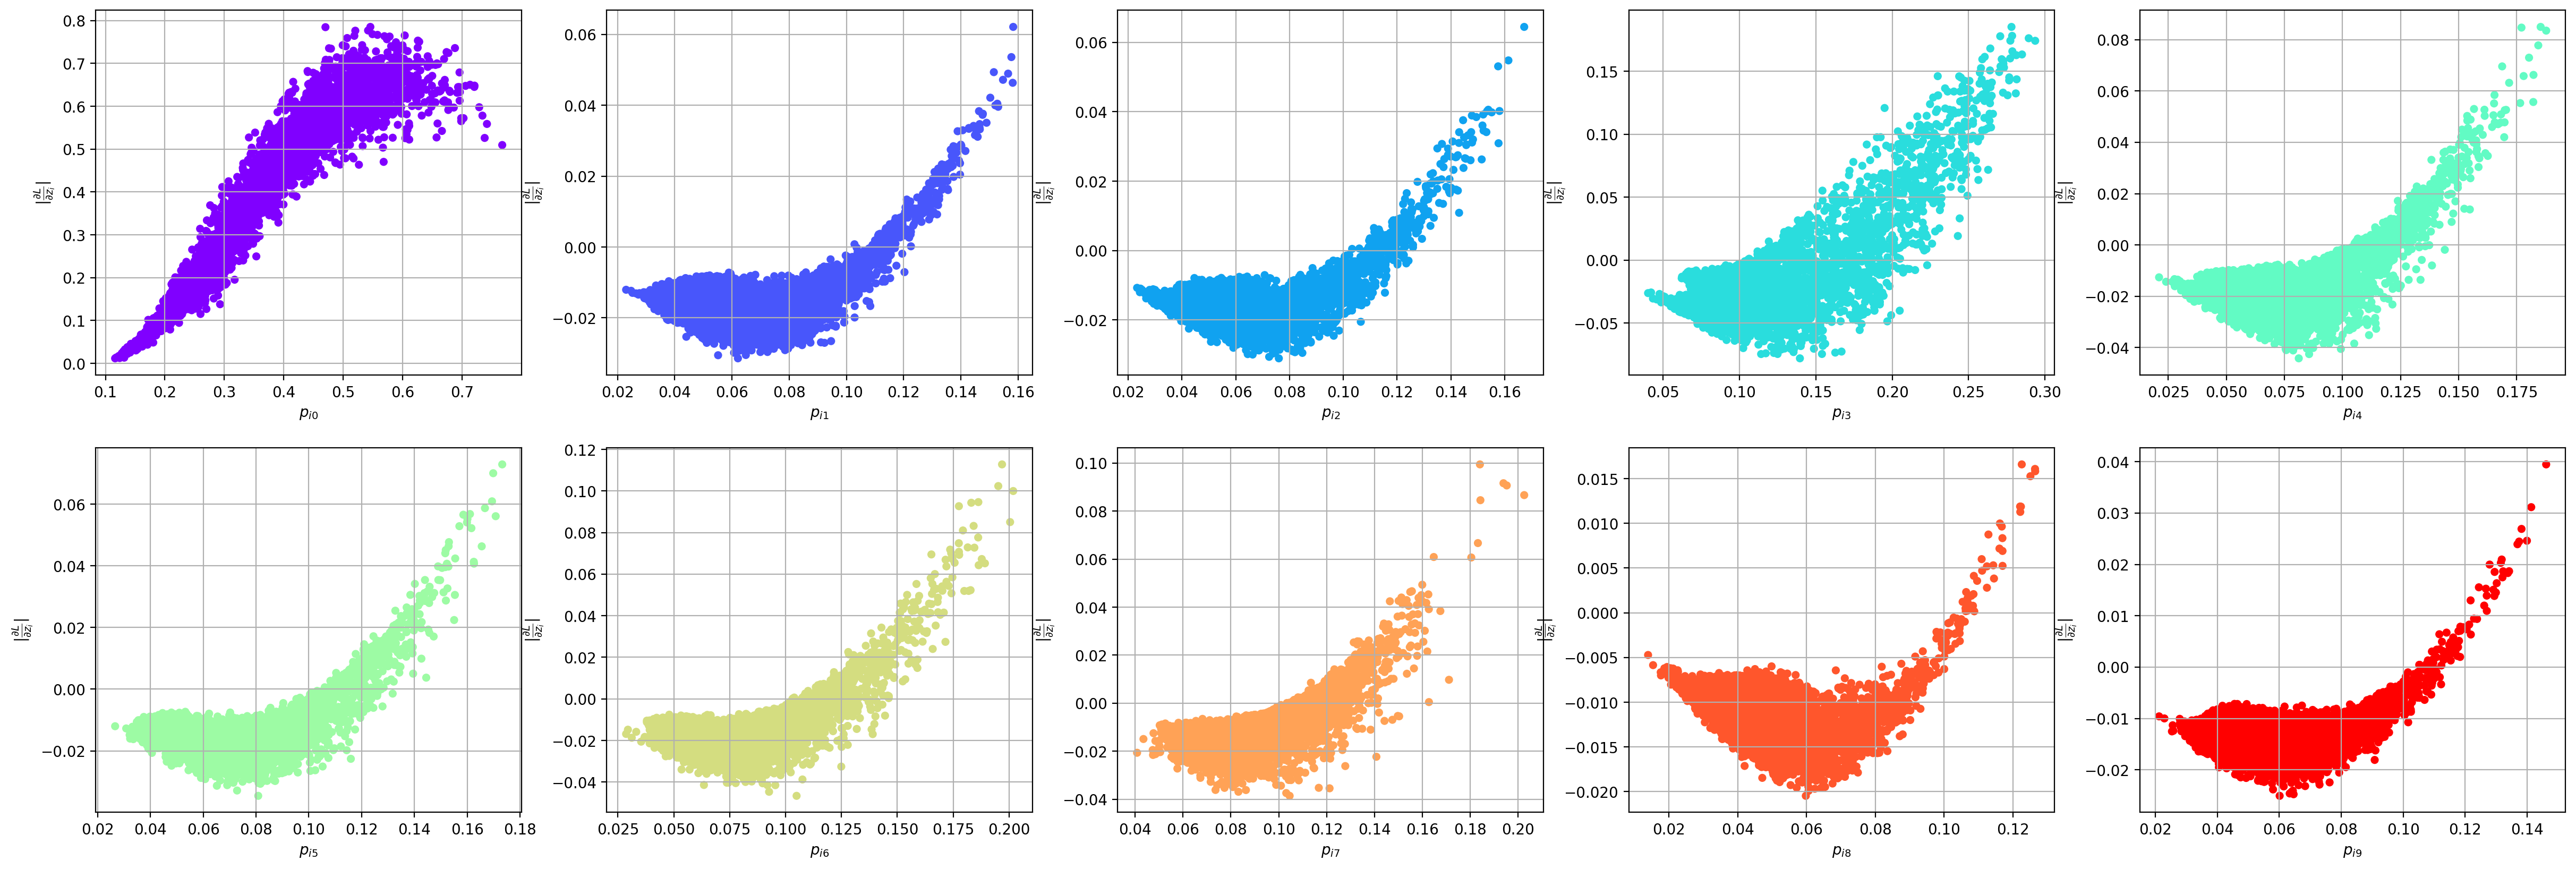

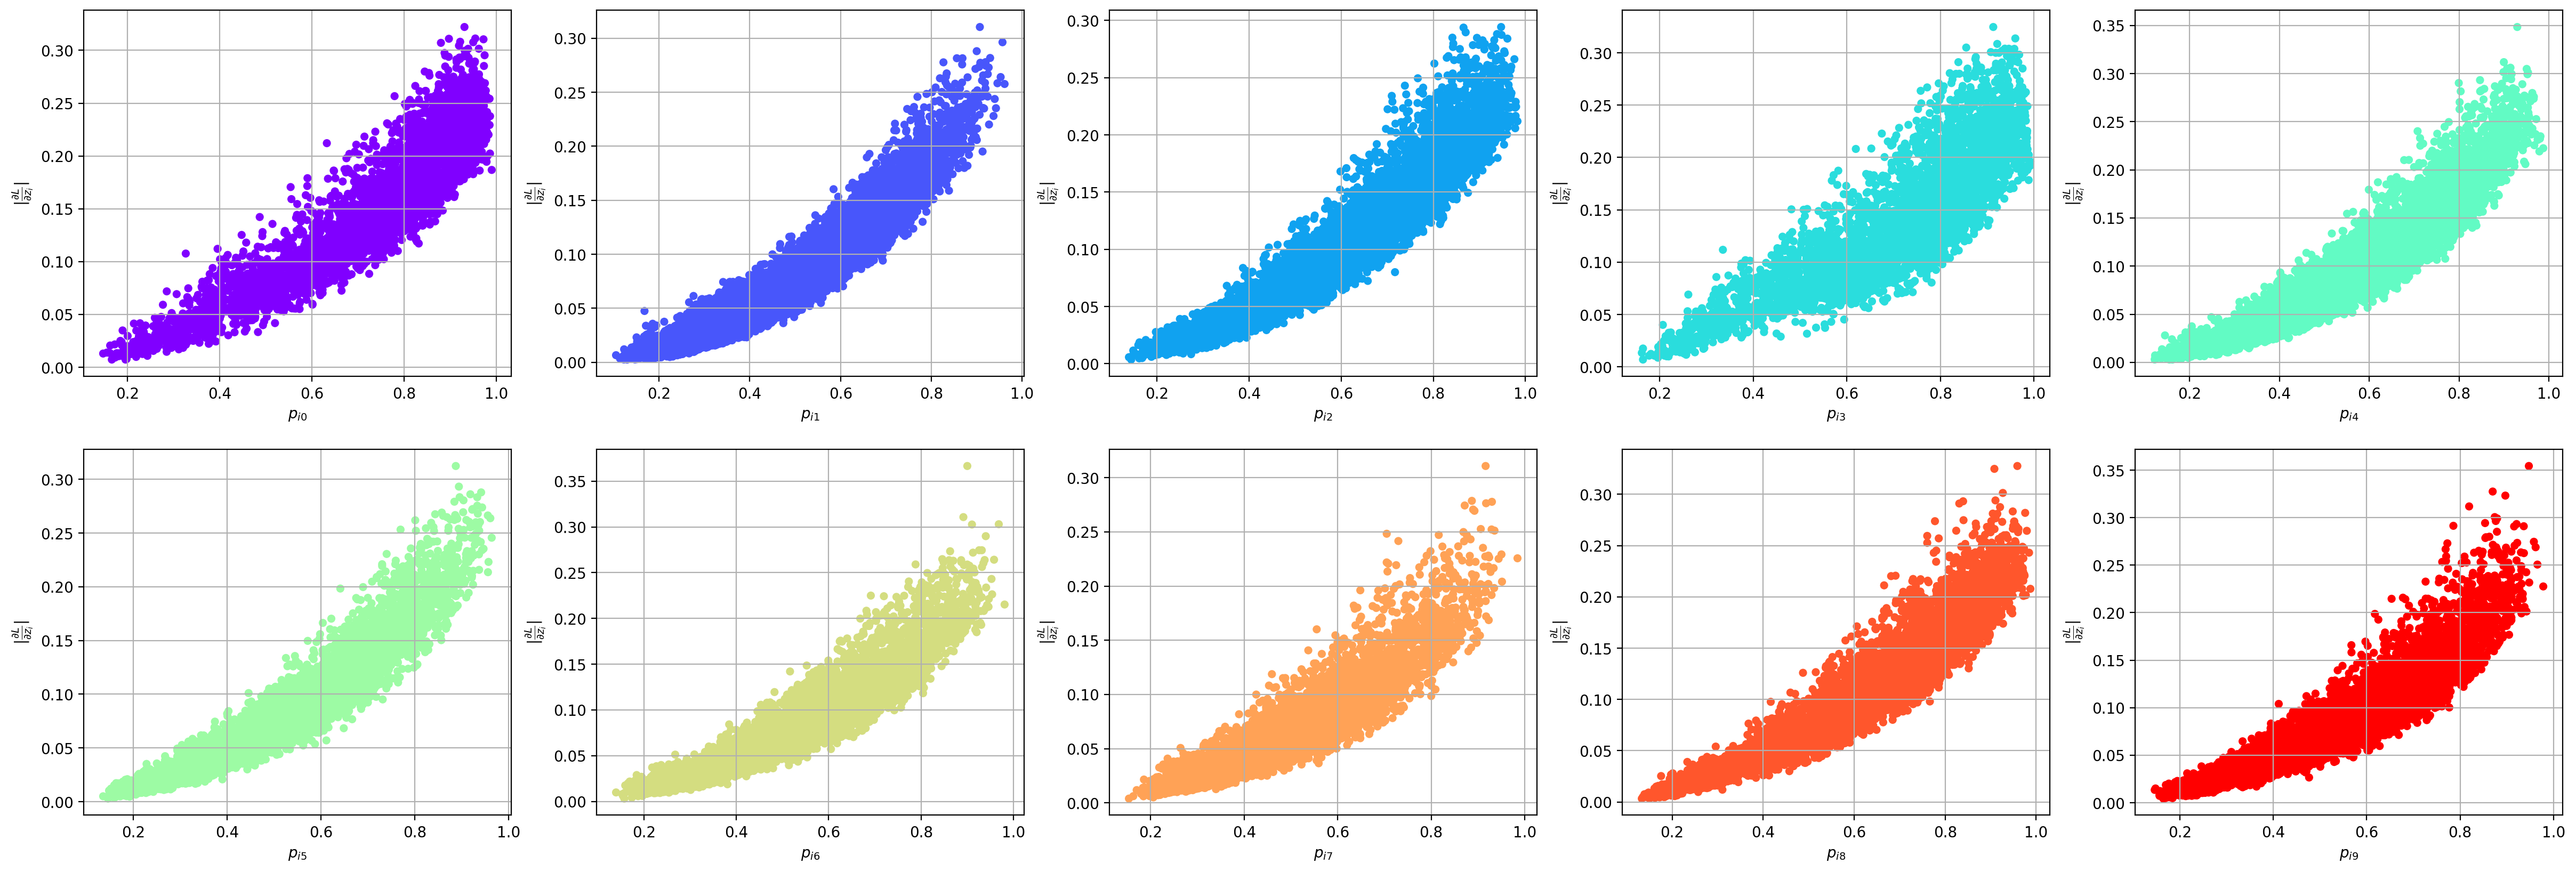

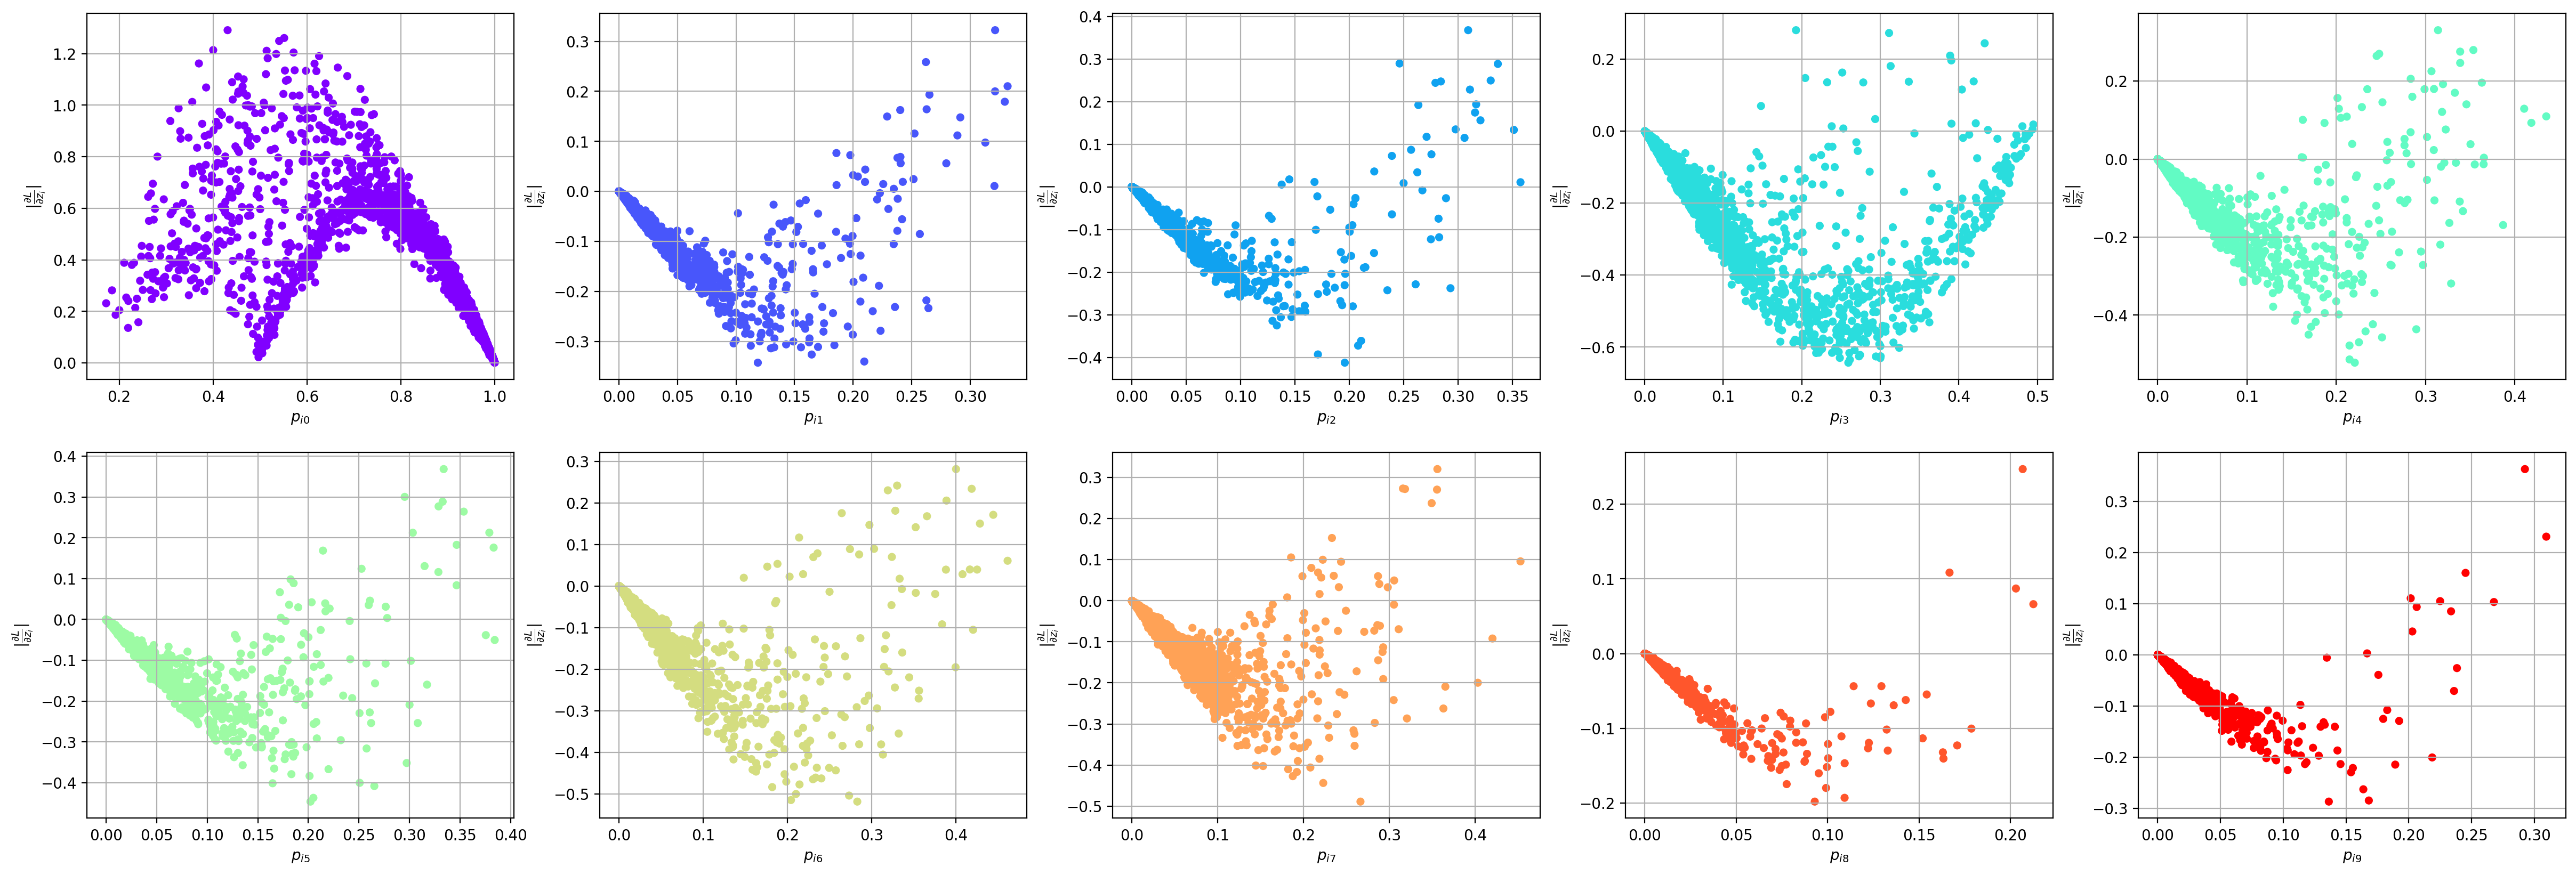

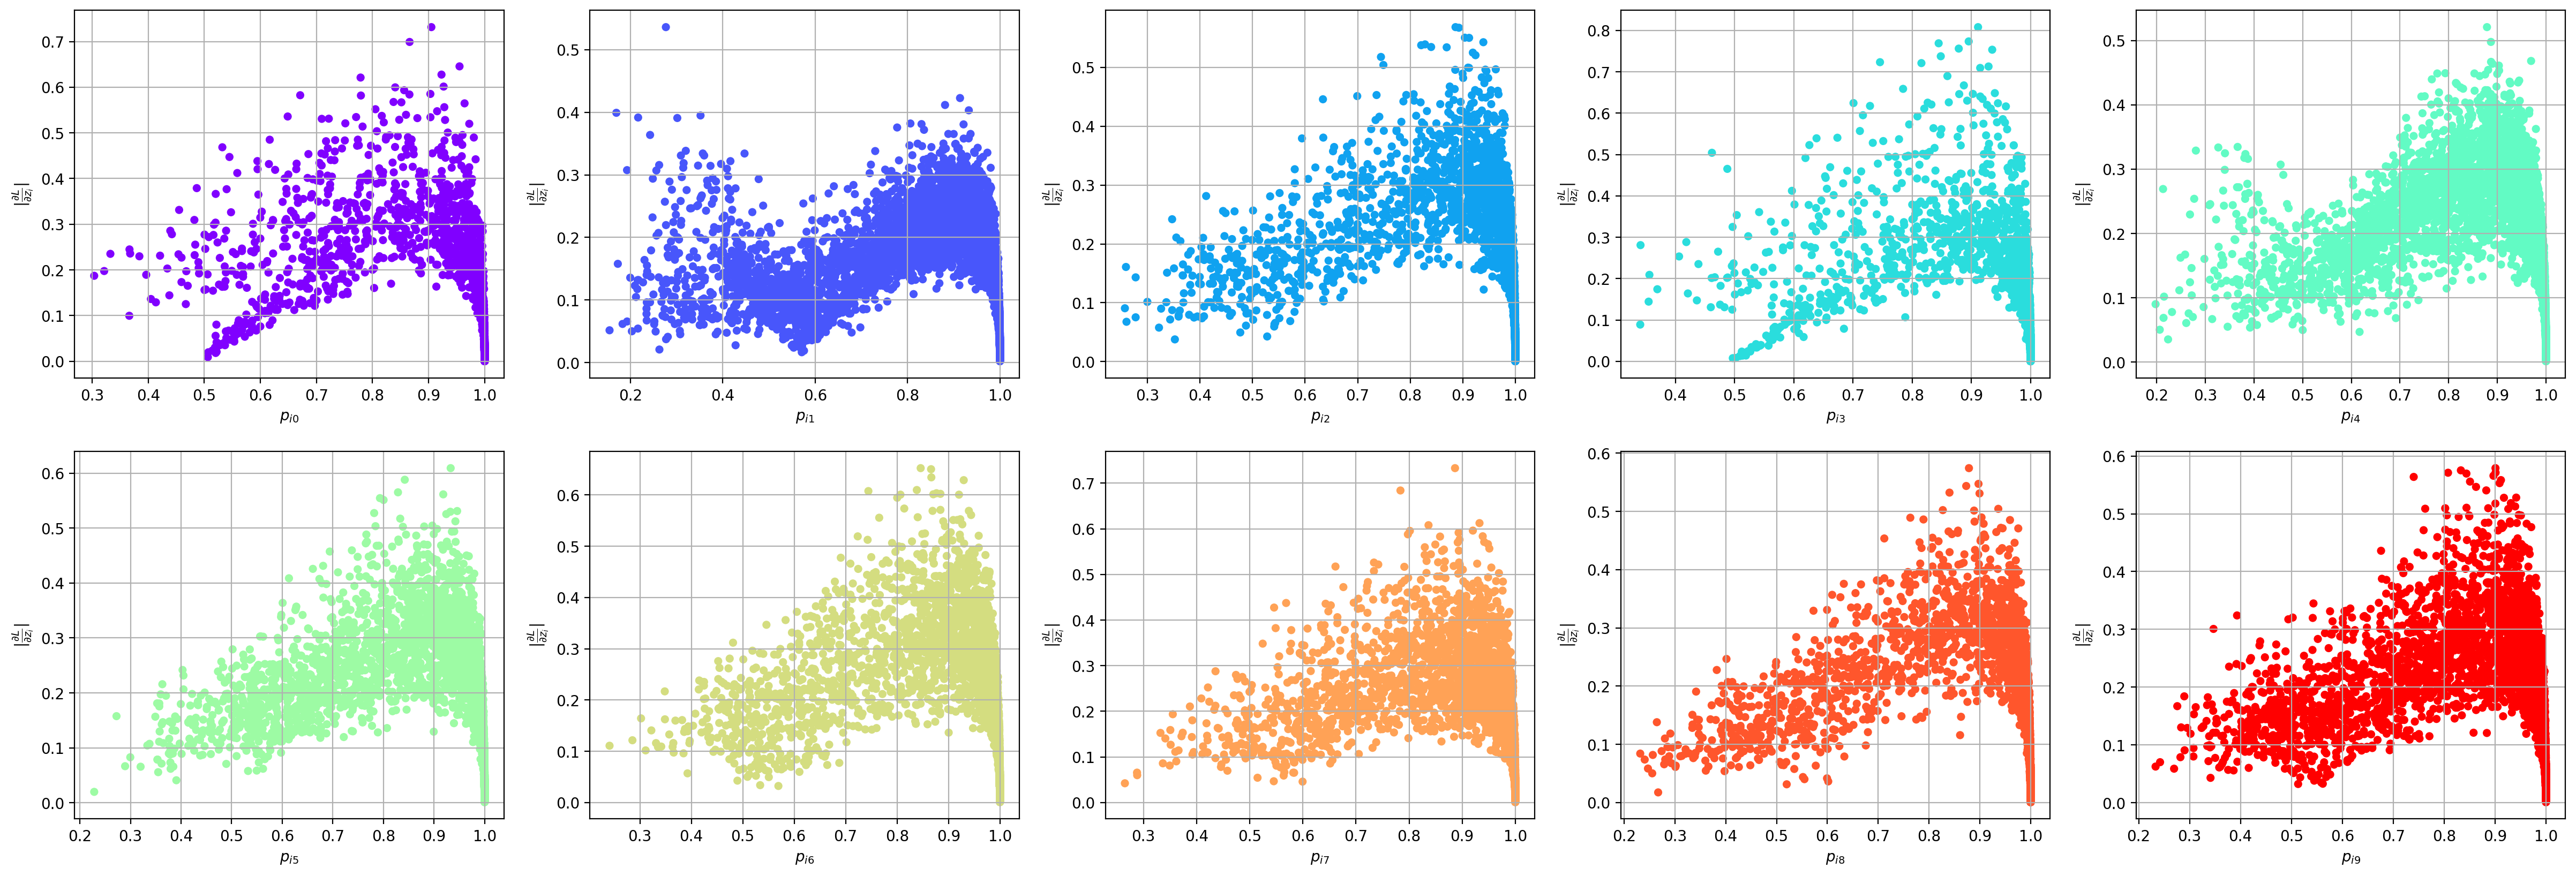

In [8]:
## Gradients plot
for alpha in [1, 9]:
    # set weights
    encoder.set_weights(encoder_ft_param)
    # initializing clustering model
    clustering_model = create_clustering_model(
        n_clusters=N_CLUSTERS,
        alpha=alpha,
        encoder=encoder)
    # compiling the clustering model (necessary for evaluating)
    clustering_model.compile(
        loss='kld')
    clustering_model.get_layer(
        name='clustering').set_weights([initial_centroids])
    cl_layer = clustering_model.get_layer(name='clustering')
    # get soft assignments
    q = clustering_model(x_train).numpy()
    p = target_distribution(q)
    initial_pred = q.argmax(1)

    # compute gradients
    z = encoder(x_train).numpy()
    qq = (q.T/q.sum(axis=1)).T
    pp = (qq**2)
    pp = (pp.T/pp.sum(axis=1)).T
    grad = ((alpha+1.0)/alpha)/(1.0+cdist(z, initial_centroids, 'sqeuclidean')/alpha)*(pp-qq)*cdist(z, initial_centroids, 'cityblock')

    fig, axs = plt.subplots(2, int(N_CLUSTERS/2),
                            figsize=(30, 10),
                            squeeze=True,
                            facecolor='white',
                            dpi=200)
    k=0
    ind = np.bincount(q.argmax(axis=1)).argmin()
    colors = cm.rainbow(np.linspace(0, 1, N_CLUSTERS))
    for i in range(2):
        for j in range(int(N_CLUSTERS/2)):
            idx = (initial_pred == k)
            ax = axs[i, j]
            scatter = ax.scatter(qq[idx, ind],
                                 grad[idx, ind],
                                 color=colors[k],
                                 s=[20]*len(p[idx, k]),
                                 )
            ax.set_xlabel(r'$p_{i%d}$' % k)
            ax.set_ylabel(r'$|\frac{\partial L}{\partial z_i}|$')
            ax.grid()
            k+=1
    plt.savefig(results_path/'initial_gradients_dec_alpha{}.png'.format(alpha),
                facecolor=fig.get_facecolor(),
                edgecolor='none')


    datapoints = tf.Variable(x_train, dtype=tf.float32)
    soft_assignments = tf.Variable(p)

    with tf.GradientTape() as tape:
        embedded_points = encoder(datapoints)
        outputs = cl_layer(embedded_points)
        kld = kl_divergence(soft_assignments, outputs)
        dc_da = tape.gradient(kld, embedded_points)

    norm_dc_da = np.linalg.norm(dc_da, axis=1)

    fig, axs = plt.subplots(2, int(N_CLUSTERS/2),
                            figsize=(30, 10),
                            squeeze=True,
                            facecolor='white',
                            dpi=200)
    k=0
    colors = cm.rainbow(np.linspace(0, 1, N_CLUSTERS))
    for i in range(2):
        for j in range(int(N_CLUSTERS/2)):
            idx = (initial_pred == k)
            ax = axs[i, j]
            scatter = ax.scatter(p[idx, k],
                                 norm_dc_da[idx],
                                 color=colors[k],
                                 s=[20]*len(p[idx, k]),
                                 )
            ax.set_xlabel(r'$p_{i%d}$' % k)
            ax.set_ylabel(r'$|\frac{\partial L}{\partial z_i}|$')
            ax.grid()
            k+=1
    plt.savefig(results_path/'initial_gradients_alpha{}.png'.format(alpha),
                facecolor=fig.get_facecolor(),
                edgecolor='none')

In [9]:
encoder.set_weights(encoder_final_param)
z = encoder(x_train).numpy()

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(z[idx, :]))
        a = np.concatenate((z, centroids), axis=0)
    
    tsne = TSNE(n_components=2,
                n_jobs=-1,
                random_state=51550).fit_transform(a)
    
    points = pd.DataFrame(tsne[:len(x_train)], columns=['x0', 'x1'])
    centroids = pd.DataFrame(tsne[len(x_train):], columns=['x0', 'x1'])
    centroids['y'] = ['label {}'.format(l) for l in np.unique(labels)]
    centroids['y'] = centroids['y'].astype("category")
    points['y'] = ['label {}'.format(l) for l in labels]
    points['y'] = points['y'].astype("category")
    
    fig, ax = plt.subplots(figsize=(16, 8))
    x_range = (np.min(points['x0'])-0.1, np.max(points['x0'])+0.1)
    y_range = (np.min(points['x1'])-0.1, np.max(points['x1'])+0.1)
    
    agg = ds.count()
    cmap = None
    if centroids is not None:
        cmap = 'tab10'
        dsshow(df=centroids, glyph=ds.Point('x0','x1'), aggregator=ds.count_cat('y'), ax=ax,
            shade_hook=partial(dtf.spread, px=5, shape='square'), cmap=cmap, x_range=x_range, y_range=y_range)
        agg = ds.count_cat('y')
        
    artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
            shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
    #ax.legend(handles=artist.get_legend_elements())
    plt.grid()
    plt.xlabel(r'$\tilde{x}_0$')
    plt.ylabel(r'$\tilde{x}_1$')
    plt.savefig(results_path/'cluster_tsne_space_{}.png'.format(desc))
    plt.show()
    #plt.close()

Visualizing dec labels


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/STUDENTI/lorenzo.sani/mambaforge/envs/logu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-e9224c476442>", line 16, in <module>
    X_feature_embedded = TSNE(n_components=2,
  File "/home/STUDENTI/lorenzo.sani/mambaforge/envs/logu/lib/python3.9/site-packages/MulticoreTSNE/__init__.py", line 139, in fit_transform
    t.join(timeout=1.0)
  File "/home/STUDENTI/lorenzo.sani/mambaforge/envs/logu/lib/python3.9/threading.py", line 1037, in join
    self._wait_for_tstate_lock(timeout=max(timeout, 0))
  File "/home/STUDENTI/lorenzo.sani/mambaforge/envs/logu/lib/python3.9/threading.py", line 1049, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/STUDENTI/lorenzo.sani/mambaforge/envs

TypeError: object of type 'NoneType' has no len()

In [ ]:
encoder.set_weights(encoder_ft_param)
z = encoder(x_train).numpy()

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(z[idx, :]))
        a = np.concatenate((z, centroids), axis=0)
    
    tsne = TSNE(n_components=2,
                n_jobs=-1,
                random_state=51550).fit_transform(a)
    
    points = pd.DataFrame(tsne[:len(x_train)], columns=['x0', 'x1'])
    centroids = pd.DataFrame(tsne[len(x_train):], columns=['x0', 'x1'])
    centroids['y'] = ['label {}'.format(l) for l in np.unique(labels)]
    centroids['y'] = centroids['y'].astype("category")
    points['y'] = ['label {}'.format(l) for l in labels]
    points['y'] = points['y'].astype("category")
    
    fig, ax = plt.subplots(figsize=(16, 8))
    x_range = (np.min(points['x0'])-0.1, np.max(points['x0'])+0.1)
    y_range = (np.min(points['x1'])-0.1, np.max(points['x1'])+0.1)
    
    agg = ds.count()
    cmap = None
    if centroids is not None:
        cmap = 'tab10'
        dsshow(df=centroids, glyph=ds.Point('x0','x1'), aggregator=ds.count_cat('y'), ax=ax,
            shade_hook=partial(dtf.spread, px=5, shape='square'), cmap=cmap, x_range=x_range, y_range=y_range)
        agg = ds.count_cat('y')
        
    artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
            shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
    #ax.legend(handles=artist.get_legend_elements())
    plt.grid()
    plt.xlabel(r'$\tilde{x}_0$')
    plt.ylabel(r'$\tilde{x}_1$')
    plt.savefig(results_path/'cluster_tsne_space_{}.png'.format(desc))
    plt.show()
    #plt.close()

In [30]:
encoder.set_weights(encoder_param)
z = encoder(x_test).numpy()
tsne = TSNE(n_components=2, random_state=51550).fit_transform(z)
points = pd.DataFrame(tsne, columns=['x0', 'x1'])
fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-0.1, np.max(points['x0'])+0.1)
y_range = (np.min(points['x1'])-0.1, np.max(points['x1'])+0.1)
artist = dsshow(points, ds.Point('x0','x1'), ds.count(), ax=ax,
      shade_hook=partial(dtf.spread, px=2), x_range=x_range, y_range=y_range)
ax.grid()
ax.set_xlabel(r'$\tilde{x}_0$')
ax.set_ylabel(r'$\tilde{x}_1$')
plt.savefig(results_path/'pretrain_tsne_space.png')
#plt.close()

KeyboardInterrupt: 

In [28]:
encoder.set_weights(encoder_final_param)
z = encoder(x_train).numpy()
    
points = pd.DataFrame(z, columns=['z{}'.format(i) for i in range(10)])

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(z[idx, :]))
    
    centroids = pd.DataFrame(centroids, columns=['z{}'.format(i) for i in np.unique(labels)])
    centroids['y'] = ['label {}'.format(l) for l in np.unique(labels)]
    centroids['y'] = centroids['y'].astype("category")
    points['y'] = ['label {}'.format(l) for l in labels]
    points['y'] = points['y'].astype("category")
    
    fig, axs = plt.subplots(dims[-1], dims[-1],
                            figsize=(8*dims[-1], 4*dims[-1]),
                            squeeze=False,
                            facecolor='white',
                            dpi=200)
    for i in range(dims[-1]):
        for j in range(dims[-1]):
            ax = axs[i, j]
            x_range = (np.min(points['z{}'.format(i)])-0.1, np.max(points['z{}'.format(i)])+0.1)
            y_range = (np.min(points['z{}'.format(j)])-0.1, np.max(points['z{}'.format(j)])+0.1)
            if i!=j:
                agg = ds.count()
                cmap = None
                if centroids is not None:
                    cmap = 'tab10'
                    dsshow(df=centroids, glyph=ds.Point('z{}'.format(i),'z{}'.format(j)), aggregator=ds.count_cat('y'), ax=axs[i, j],
                      shade_hook=partial(dtf.spread, px=5, shape='square'), cmap=cmap, x_range=x_range, y_range=y_range)
                    agg = ds.count_cat('y')
                    
                artist = dsshow(df=points, glyph=ds.Point('z{}'.format(i),'z{}'.format(j)), aggregator=agg, ax=axs[i, j],
                      shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
                #ax.legend(handles=artist.get_legend_elements())
            ax.grid()
            ax.set_xlabel(r'$z_{%d}$' % i)
            ax.set_ylabel(r'$z_{%d}$' % j)
    plt.savefig(results_path/'cluster_feature_space_{}.png'.format(desc),
                facecolor=fig.get_facecolor(),
                edgecolor='none')
    plt.close()

Visualizing dec labels
Visualizing kmeans labels
Visualizing ground_truth labels


In [29]:
encoder.set_weights(encoder_ft_param)
z = encoder(x_train).numpy()
    
points = pd.DataFrame(z, columns=['z{}'.format(i) for i in range(10)])

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(z[idx, :]))
    
    centroids = pd.DataFrame(centroids, columns=['z{}'.format(i) for i in np.unique(labels)])
    centroids['y'] = ['label {}'.format(l) for l in np.unique(labels)]
    centroids['y'] = centroids['y'].astype("category")
    points['y'] = ['label {}'.format(l) for l in labels]
    points['y'] = points['y'].astype("category")
    
    fig, axs = plt.subplots(dims[-1], dims[-1],
                            figsize=(8*dims[-1], 4*dims[-1]),
                            squeeze=False,
                            facecolor='white',
                            dpi=200)
    for i in range(dims[-1]):
        for j in range(dims[-1]):
            ax = axs[i, j]
            x_range = (np.min(points['z{}'.format(i)])-0.1, np.max(points['z{}'.format(i)])+0.1)
            y_range = (np.min(points['z{}'.format(j)])-0.1, np.max(points['z{}'.format(j)])+0.1)
            if i!=j:
                agg = ds.count()
                cmap = None
                if centroids is not None:
                    cmap = 'tab10'
                    dsshow(df=centroids, glyph=ds.Point('z{}'.format(i),'z{}'.format(j)), aggregator=ds.count_cat('y'), ax=axs[i, j],
                      shade_hook=partial(dtf.spread, px=5, shape='square'), cmap=cmap, x_range=x_range, y_range=y_range)
                    agg = ds.count_cat('y')
                    
                artist = dsshow(df=points, glyph=ds.Point('z{}'.format(i),'z{}'.format(j)), aggregator=agg, ax=axs[i, j],
                      shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
                #ax.legend(handles=artist.get_legend_elements())
            ax.grid()
            ax.set_xlabel(r'$z_{%d}$' % i)
            ax.set_ylabel(r'$z_{%d}$' % j)
    plt.savefig(results_path/'finetune_feature_space_{}.png'.format(desc),
                facecolor=fig.get_facecolor(),
                edgecolor='none')
    plt.close()

Visualizing dec labels
Visualizing kmeans labels
Visualizing ground_truth labels


In [25]:
encoder.set_weights(encoder_param)
z = encoder(x_test).numpy()
    
points = pd.DataFrame(z, columns=['z{}'.format(i) for i in range(10)])

fig, axs = plt.subplots(dims[-1], dims[-1],
                        figsize=(8*dims[-1], 4*dims[-1]),
                        squeeze=False,
                        facecolor='white',
                        dpi=200)
for i in range(dims[-1]):
    for j in range(dims[-1]):
        ax = axs[i, j]
        x_range = (np.min(points['z{}'.format(i)])-0.1, np.max(points['z{}'.format(i)])+0.1)
        y_range = (np.min(points['z{}'.format(j)])-0.1, np.max(points['z{}'.format(j)])+0.1)
        if i!=j:
            artist = dsshow(points, ds.Point('z{}'.format(i),'z{}'.format(j)), ds.count(), ax=axs[i, j],
                  shade_hook=partial(dtf.spread, px=2), x_range=x_range, y_range=y_range)
        ax.grid()
        ax.set_xlabel(r'$z_{%d}$' % i)
        ax.set_ylabel(r'$z_{%d}$' % j)
plt.savefig(results_path/'pretrain_feature_space_{}.png'.format(desc),
            facecolor=fig.get_facecolor(),
            edgecolor='none')
plt.close()

In [ ]:
## Example BMNIST digits
figure = plt.figure(figsize=(20, 4))
j = 0

for example in x_train[:10]:
  plt.subplot(2, 5, j+1)
  plt.imshow(example.reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

In [ ]:
## Example BMNIST digits from pretrained autoencoder
encoder.set_weights(encoder_param)
figure = plt.figure(figsize=(20, 4))
j = 0

for example in autoencoder(x_train[:10]):
  plt.subplot(2, 5, j+1)
  plt.imshow(example.numpy().reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

In [ ]:
## Example BMNIST digits from finetuned autoencoder
encoder.set_weights(encoder_ft_param)
figure = plt.figure(figsize=(20, 4))
j = 0

for example in autoencoder(x_train[:10]):
  plt.subplot(2, 5, j+1)
  plt.imshow(example.numpy().reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

In [ ]:
## Example BMNIST digits from final model
encoder.set_weights(encoder_final_param)
figure = plt.figure(figsize=(20, 4))
j = 0

for example in autoencoder(x_train[:10]):
  plt.subplot(2, 5, j+1)
  plt.imshow(example.numpy().reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1